Primero que nada, importamos nuestras librerías. Luego, descargamos nuestra URL y transformamos nuestro HTML con BeautifulSoup.

In [21]:
from bs4 import BeautifulSoup
import pandas as pd 
import requests
import time
import pymysql
import re
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
url_recurso = "https://www.macrotrends.net/stocks/charts/TSLA/tesla/revenue"
respuesta = requests.get(url_recurso,time.sleep(10),headers=headers)
soup = BeautifulSoup(respuesta.text,'html.parser')
if respuesta.status_code != 200:
    raise Exception(f"Error al acceder a la URL: {url}")

Ahora buscamos todas las tablas para encontrar la que tenga la evolución trimestral y convertirla en un dataframe.


In [3]:
tables = soup.find_all('table')

df = pd.read_html(str(tables[1]))
data_frame = df[0]
data_frame.columns = ['Date','Revenue'] 
data_frame['Revenue'] = data_frame['Revenue'].str.replace('[$,]', '',regex= True)
data_frame = data_frame.dropna()
print(data_frame.head())

         Date Revenue
0  2023-12-31   25167
1  2023-09-30   23350
2  2023-06-30   24927
3  2023-03-31   23329
4  2022-12-31   24318


C:\Users\jdean\AppData\Local\Temp\ipykernel_7556\1198964488.py:3: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(tables[1]))


En este caso vamos a llevarlo al servidor sql 

In [75]:
import pymysql
connection = pymysql.connect(host='localhost',
                             user='root',
                             password='Joe2022098',
                             port= 3306,
                             database='base_de_datos_prueba')
cursor = connection.cursor()

crear_tabla_ = """
CREATE TABLE IF NOT EXISTS Evolucion (
    Date DATE,
    Revenue INT  
)
"""
cursor.execute(crear_tabla_)
connection.commit()

In [81]:


for row in data_frame.to_records(index=False):
    cursor.execute("INSERT INTO Evolucion (Date, Revenue) VALUES (%s, %s)", (row.Date, row.Revenue))
connection.commit()

In [83]:
cursor.execute("SELECT * FROM Evolucion")
registros = cursor.fetchall()
registros

((datetime.date(2023, 12, 31), 25167),
 (datetime.date(2023, 9, 30), 23350),
 (datetime.date(2023, 6, 30), 24927),
 (datetime.date(2023, 3, 31), 23329),
 (datetime.date(2022, 12, 31), 24318),
 (datetime.date(2022, 9, 30), 21454),
 (datetime.date(2022, 6, 30), 16934),
 (datetime.date(2022, 3, 31), 18756),
 (datetime.date(2021, 12, 31), 17719),
 (datetime.date(2021, 9, 30), 13757),
 (datetime.date(2021, 6, 30), 11958),
 (datetime.date(2021, 3, 31), 10389),
 (datetime.date(2020, 12, 31), 10744),
 (datetime.date(2020, 9, 30), 8771),
 (datetime.date(2020, 6, 30), 6036),
 (datetime.date(2020, 3, 31), 5985),
 (datetime.date(2019, 12, 31), 7384),
 (datetime.date(2019, 9, 30), 6303),
 (datetime.date(2019, 6, 30), 6350),
 (datetime.date(2019, 3, 31), 4541),
 (datetime.date(2018, 12, 31), 7226),
 (datetime.date(2018, 9, 30), 6824),
 (datetime.date(2018, 6, 30), 4002),
 (datetime.date(2018, 3, 31), 3409),
 (datetime.date(2017, 12, 31), 3288),
 (datetime.date(2017, 9, 30), 2985),
 (datetime.date(20

Ahora vamos a graficar

C:\Users\jdean\AppData\Local\Temp\ipykernel_7556\3750713404.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['Date']=pd.to_datetime(data_frame['Date'])
C:\Users\jdean\AppData\Local\Temp\ipykernel_7556\3750713404.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['Revenue'] = data_frame['Revenue'].astype('int')


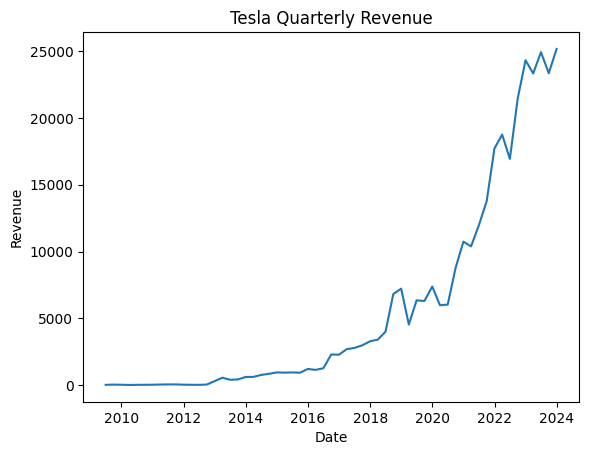

In [11]:
import matplotlib.pyplot as plt
data_frame['Date']=pd.to_datetime(data_frame['Date'])
data_frame['Revenue'] = data_frame['Revenue'].astype('int')
plt.plot(data_frame['Date'],data_frame['Revenue'])
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Tesla Quarterly Revenue')
plt.show()

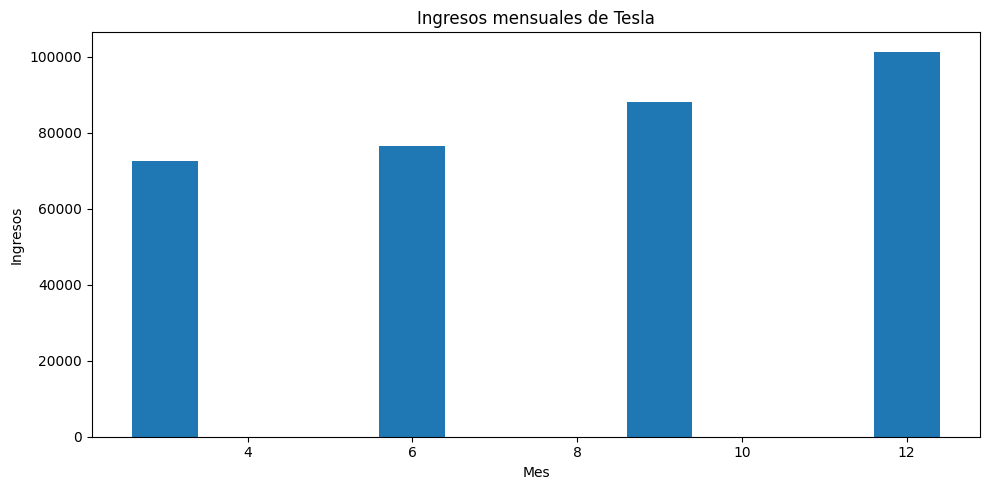

,Date,Revenue
0,3,72475
1,6,76536
2,9,88147
3,12,101298


In [19]:
mensual = data_frame.groupby(data_frame["Date"].dt.month)["Revenue"].sum().reset_index()
fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(mensual["Date"], mensual["Revenue"])
ax.set_xlabel("Mes")
ax.set_ylabel("Ingresos")
ax.set_title("Ingresos mensuales de Tesla")
plt.tight_layout()
plt.show()

mensual